In [43]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess

weights_url = 'https://pjreddie.com/media/files/yolov3.weights'
names_url = 'https://raw.githubusercontent.com/pjreddie/darknet/refs/heads/master/data/coco.names'
cfg_url = 'https://raw.githubusercontent.com/pjreddie/darknet/refs/heads/master/cfg/yolov3.cfg'


def load_url(url):

  process = subprocess.Popen(['wget', url],
                             stdout=subprocess.PIPE
                            )
  output, error = process.communicate()
  print(output,error)
  return output

class ObjectDetector():

   def __init__(self,image,weights_url=None, names_url=None,cfg_url=None) -> None:

      if not weights_url is None:
       load_url(weights_url)
      if not names_url is None:
         load_url(names_url)
      if not cfg_url is None:
          load_url(cfg_url)

      self.image=cv2.imread(image)
      self.height=self.image.shape[0]
      self.width=self.image.shape[1]
      self.scale= 1./256
      self.model=cv2.dnn.readNet(model='yolov3.weights',config='yolov3.cfg')
      blob=cv2.dnn.blobFromImage(self.image,scalefactor=self.scale,size=(416,416),mean=(0,0,0),swapRB=True,crop=False)
      self.model.setInput(blob)
      self.classes=None
      with open('coco.names','r') as f:
          self.classes=[line.strip() for line in f.readlines()]
          # Get an arraay of RGB colors for each name in the coco.names file(for each class)
          self.COLORS=np.random.uniform(0,255,size=(len(self.classes),3))
      print('Number of classes = ', len(self.classes))


   def _get_output_layers(self,net):
            layer_names=net.getLayerNames()
            output_layers=[layer_names[i-1] for i in net.getUnconnectedOutLayers()]
            return output_layers
   # draw bounding box and put label
   def _draw_bounding_box(self,img,class_id,confidence,x,y,x_plus_w,y_plus_h):

            label=str(self.classes[class_id])
            color=self.COLORS[class_id]
            cv2.rectangle(img,(x,y),(x_plus_w,y_plus_h),color,2)
            cv2.putText(img,label,(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

   def detect(self):
        outs= self.model.forward(self._get_output_layers(self.model))
        class_ids=[]
        confidences=[]
        boxes=[]
        conf_threshold=0.5
        nms_threshold=0.4

        for out in outs:
          for detection in out:
            scores=detection[5:]
            class_id=np.argmax(scores)
            confidence=scores[class_id]
            if confidence>0.5:
              center_x=int(detection[0]*self.width)
              center_y=int(detection[1]*self.height)
              w=int(detection[2]*self.width)
              h=int(detection[3]*self.height)
              x=center_x-w/2
              y=center_y-h/2
              class_ids.append(class_id)
              confidences.append(float(confidence))
              boxes.append([x,y,w,h])
        indices=cv2.dnn.NMSBoxes(boxes,confidences,conf_threshold,nms_threshold)
        for i in indices:
              box=boxes[i]
              left=box[0]
              top=box[1]
              width=box[2]
              height=box[3]
              self._draw_bounding_box(self.image,class_ids[i],confidences[i],int(left),int(top),int(left+width),int(top+height))



        cv2_imshow(self.image)

Number of classes =  80


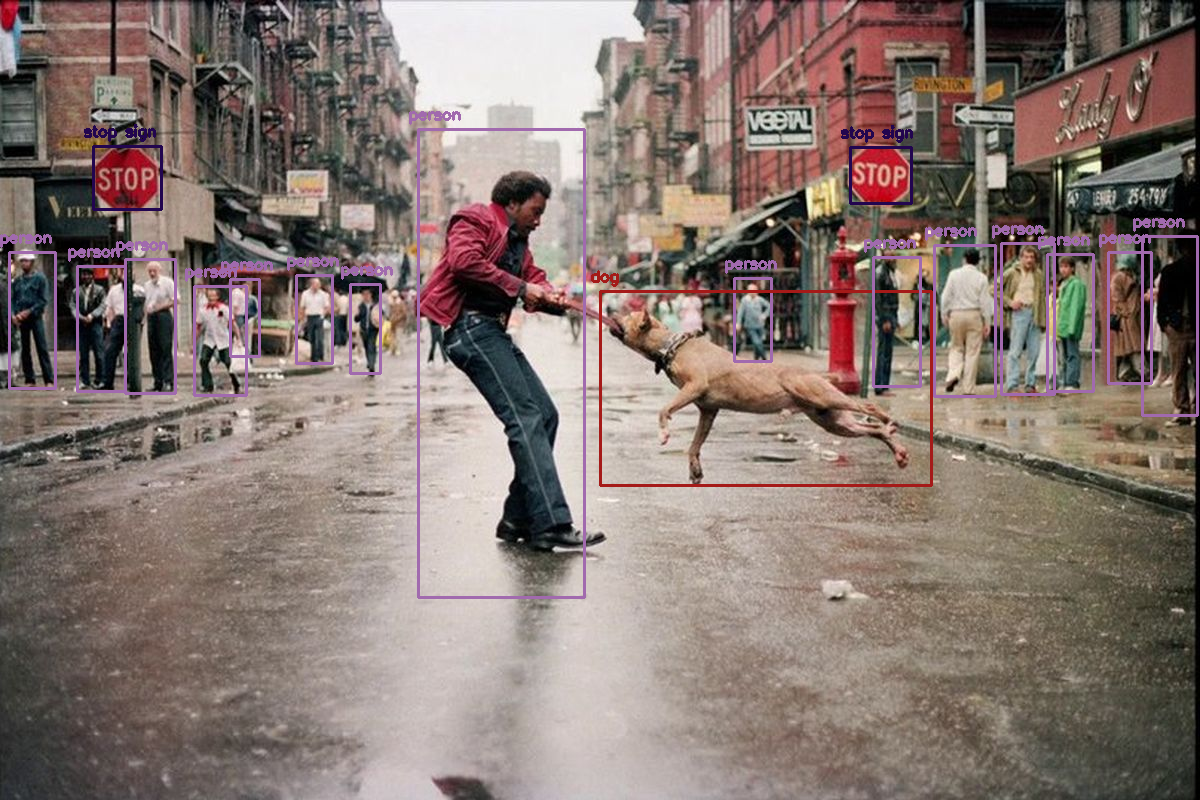

In [44]:
obj_det = ObjectDetector('/content/everybody_street.jpg')
obj_det.detect()
